In [2]:
import tensorflow as tf
print(tf.version.VERSION)

2.17.0


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from collections import Counter
from itertools import islice

In [4]:
# One class per digit
NUM_CLASSES = 10

In [5]:
train_dataset, test_dataset = [tf.data.Dataset.from_tensor_slices(tup).map(lambda image, label: (tf.convert_to_tensor(tf.expand_dims(image, -1)), 
                                                                                                 int(tf.keras.utils.to_categorical(label, NUM_CLASSES)))
                                                                          ) for tup in tf.keras.datasets.mnist.load_data()]

In [6]:
print('Images in the train set: {}'.format(train_dataset.cardinality().numpy()))
print('Images in the test set: {}'.format(test_dataset.cardinality().numpy()))

Images in the train set: 60000
Images in the test set: 10000


In [7]:
INPUT_SHAPE = (28,28,1)

In [8]:
# Check that all images have the same format
print('All of the train dataset images are in the (28,28,1) format: {}'.format(
    np.fromiter(train_dataset.map(lambda img, _: tf.reduce_all(tf.math.equal(img.shape, tf.constant(INPUT_SHAPE)))), bool).all()))
print('All of the test dataset images are in the (28,28,1) format: {}'.format(
    np.fromiter(test_dataset.map(lambda img, _: tf.reduce_all(tf.math.equal(img.shape, tf.constant(INPUT_SHAPE)))), bool).all()))

All of the train dataset images are in the (28,28,1) format: True
All of the test dataset images are in the (28,28,1) format: True


In [9]:
# How the images are distributed between the classes?
display(pd.concat([pd.DataFrame.from_dict(Counter([np.argmax(label.numpy()) for _, label in df]), 
                   orient='index').reset_index().rename({'index':'Digit', 0:'In the {} dataset'.format(s)}, axis=1).set_index('Digit').sort_index() 
           for s, df in zip(['train', 'test'],[train_dataset, test_dataset])], axis=1))

,In the train dataset,In the test dataset
Digit,,
0,5923,980
1,6742,1135
2,5958,1032
3,6131,1010
4,5842,982
5,5421,892
6,5918,958
7,6265,1028
8,5851,974


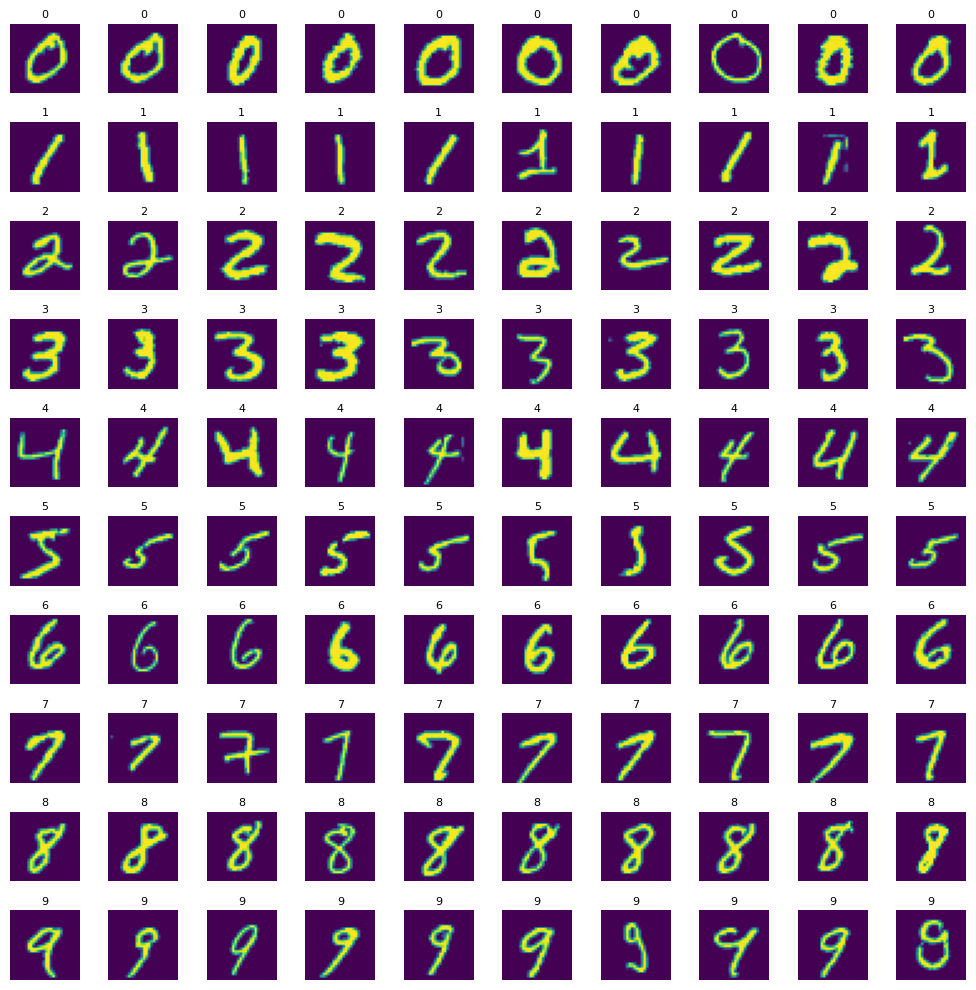

In [10]:
fig, ax = plt.subplots(10, 10, figsize=(10,10))
for i in range(10):
    for j, (image, label) in enumerate(islice(((image, label) for image, label in train_dataset if np.argmax(label.numpy())==i), 10)):
        ax[i][j].imshow(image)
        ax[i][j].set_title(i, pad = 4, fontsize=8)
for ax in ax.ravel():
    ax.set_axis_off()
plt.tight_layout()
del(fig, ax, i, j)

In [11]:
FILTERS = 24
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE, dtype=tf.float32, name="Input"),
    tf.keras.layers.Convolution2D(filters=FILTERS, kernel_size=(5, 5), activation='relu', name='Convolution'),
    tf.keras.layers.MaxPool2D(pool_size=3, name='Max_Pooling'),
    tf.keras.layers.Flatten(name='Flattening'),
    tf.keras.layers.Dense(units=256, activation='relu', name='Dense_1'),
    tf.keras.layers.Dropout(rate=0.1, name="Dropout_1"),
    tf.keras.layers.Dense(units=32, activation='relu', name='Dense_2'),
    tf.keras.layers.Dropout(rate=0.1, name="Dropout_2"),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [42]:
display(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Convolution (Conv2D)            │ (None, 24, 24, 24)     │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_Pooling (MaxPooling2D)      │ (None, 8, 8, 24)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flattening (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,207,952 (4.61 MB)

 Trainable params: 402,650 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 805,302 (3.07 MB)

None

In [13]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoints/MNIST/checkpoint.model.keras', 
                                                               monitor='categorical_accuracy', save_freq="epoch", save_best_only = True)

model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='categorical_accuracy', min_delta=0.001, patience=1, restore_best_weights=True, verbose=1)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

BATCH_SIZE = 32
EPOCHS = 10

history =  model.fit(train_dataset.batch(batch_size=BATCH_SIZE), 
              epochs = EPOCHS,
#              steps_per_epoch = len(train_dataset)//BATCH_SIZE,
              validation_data = test_dataset.batch(BATCH_SIZE), 
#              validation_steps = len(test_dataset)//BATCH_SIZE,
              callbacks = [model_checkpoint_callback, model_early_stopping],
              verbose=1)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - categorical_accuracy: 0.5721 - loss: 1.9167 - val_categorical_accuracy: 0.9743 - val_loss: 0.0995
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - categorical_accuracy: 0.9630 - loss: 0.1361 - val_categorical_accuracy: 0.9754 - val_loss: 0.0917
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - categorical_accuracy: 0.9761 - loss: 0.0905 - val_categorical_accuracy: 0.9788 - val_loss: 0.0901
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - categorical_accuracy: 0.9809 - loss: 0.0732 - val_categorical_accuracy: 0.9834 - val_loss: 0.0675
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - categorical_accuracy: 0.9823 - loss: 0.0632 - val_categorical_accuracy: 0.9845 - val_loss: 0.0707
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - categorical_accuracy: 0.9862 - loss: 0.0498 - val_categorical_accuracy: 0.9856 - val_loss: 0.0704
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - categorical_accuracy

The running stops due to the early stopping. The 7th epoche produced the best results.

In [14]:
model = tf.keras.models.load_model(filepath=model_checkpoint_callback.filepath)
model.fit(train_dataset.batch(batch_size=BATCH_SIZE), 
              epochs = 2,
              validation_data = test_dataset.batch(BATCH_SIZE), 
              verbose=1)

Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - categorical_accuracy: 0.9888 - loss: 0.0400 - val_categorical_accuracy: 0.9855 - val_loss: 0.0619
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - categorical_accuracy: 0.9919 - loss: 0.0313 - val_categorical_accuracy: 0.9863 - val_loss: 0.0828


Running the model from the weights found earlier immediately produces high out-of-sample accuracy.

In [45]:
display(pd.DataFrame.from_dict(dict(history.history.items())))

,categorical_accuracy,loss,val_categorical_accuracy,val_loss
0,0.788883,0.725614,0.9743,0.099548
1,0.967267,0.119971,0.9754,0.091688
2,0.977133,0.084009,0.9788,0.090112
3,0.981450,0.068572,0.9834,0.067517
4,0.983367,0.060314,0.9845,0.070721
5,0.986583,0.048590,0.9856,0.070394
6,0.988117,0.043222,0.9862,0.067882
7,0.988683,0.044415,0.9823,0.107970


In [16]:
final_val_loss, final_val_categorical_accuracy = model.evaluate(test_dataset.batch(1))

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 9s 931us/step - categorical_accuracy: 0.9823 - loss: 0.1156


In [17]:
predictions = model.predict(test_dataset.batch(1))

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


137 misclassified images overall
--------------------------------------------------------------------------------------------------------------------------------------------------  



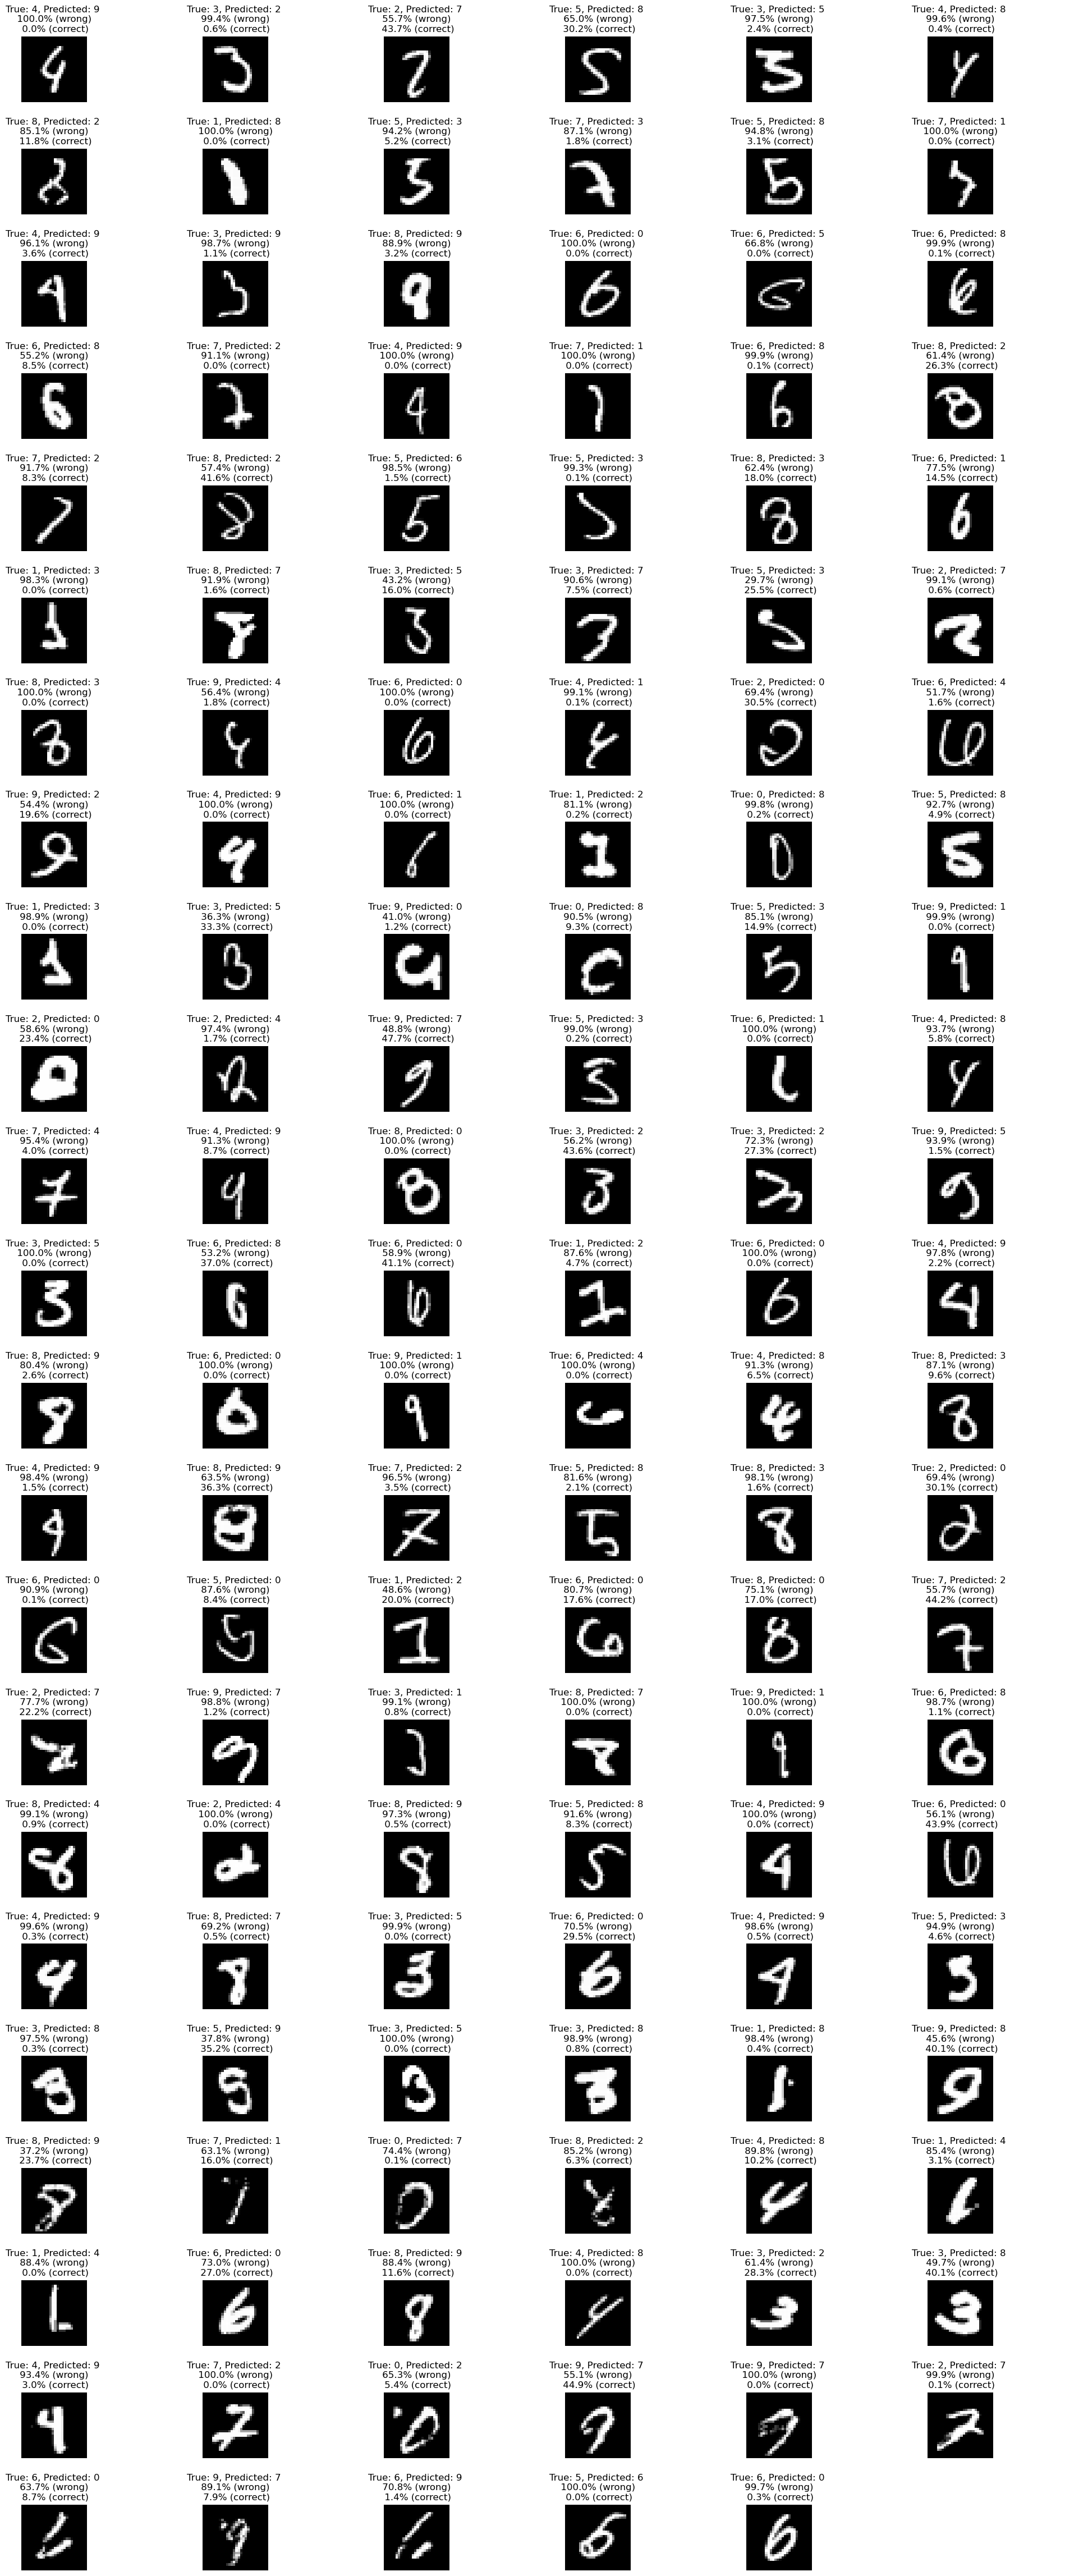

In [18]:
# Misclassifications
n_cols = 6
n_rows = int(np.ceil((1 - final_val_categorical_accuracy) * len(test_dataset) / n_cols))

fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, int(2. * n_rows)))
i = 0
for (image,label), prediction in zip(test_dataset.as_numpy_iterator(), predictions):
    if label.argmax() != prediction.argmax():
        ax[i // n_cols][i % n_cols].imshow(image,cmap='gray')
        ax[i // n_cols][i % n_cols].set_title('True: {}, Predicted: {} \n {}% (wrong) \n {}% (correct)'
                                              .format(label.argmax(), prediction.argmax(), 
                                                      round(prediction[prediction.argmax()] * 100, 1), round(prediction[label.argmax()] * 100, 1)), fontsize=12)
        i += 1

print('{} misclassified images overall'.format(i))
print('--------------------------------------------------------------------------------------------------------------------------------------------------  \n')

for ax in ax.ravel():
    ax.set_axis_off()
plt.tight_layout(h_pad=2., w_pad=1.)

del(n_rows, n_cols, fig, ax, image, label, prediction, i) 

In [19]:
# The confusion matrix
display(pd.DataFrame([(label.argmax(), prediction.argmax()) for (image,label), prediction in zip(test_dataset.as_numpy_iterator(), predictions)], columns=['True', 'Predicted']
                    ).groupby(['True', 'Predicted']).size().unstack('Predicted',fill_value=0))

Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,976,0,1,0,0,0,0,1,2,0
1,0,1126,3,2,2,0,0,0,2,0
2,3,0,1023,0,2,0,0,4,0,0
3,0,1,4,994,0,6,0,1,3,1
4,0,1,0,0,965,0,0,0,5,11
5,1,0,0,6,0,877,2,0,5,1
6,12,3,0,0,2,1,934,0,5,1
7,0,3,5,1,1,0,0,1018,0,0
8,2,0,4,4,1,0,0,3,954,6


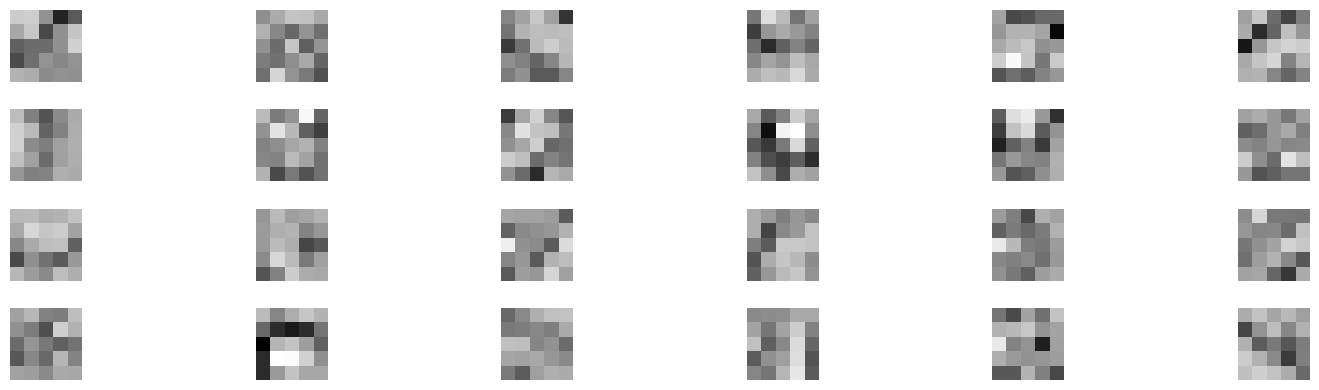

In [20]:
n_cols = 6
n_rows = int(np.ceil(FILTERS / n_cols))

fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, int(1. * n_rows)))

vmin = model.weights[0].numpy().flatten().min()
vmax = model.weights[0].numpy().flatten().max()

for i in range(FILTERS):
    ax[i // n_cols][i % n_cols].imshow(model.weights[0].numpy()[:,:, 0, i], cmap='grey', vmin = vmin, vmax = vmax)

for ax in ax.ravel():
    ax.set_axis_off()
plt.tight_layout(h_pad=2., w_pad=1.)

del(n_rows, n_cols, fig, ax, vmin, vmax, i) 